In [1]:
%pylab inline
matplotlib.style.use("ggplot")
%cd ~/LabWorkbookForTrello/
from pygments import lexers, formatters, highlight
import workbook
import pandas as pd
import collections
reload(workbook)
wb = workbook.ExperimentRepository()

Populating the interactive namespace from numpy and matplotlib
/Users/michael/LabWorkbookForTrello


#(BROKEN) Trying to reproduce the paper

- Batch size: 128
- Layer depth: 20 layers.
- Architecture: No ReLU at the end. Batch norm before adding.

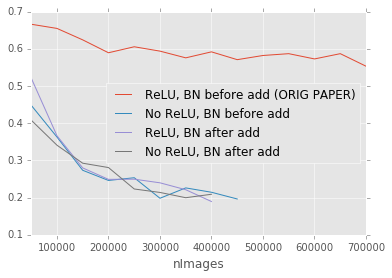

In [49]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "ReLU, BN before add (ORIG PAPER)",
    "201601102044-01lkOBJQu5": "No ReLU, BN before add",
    "201601102047-YybNsWu8zs": "ReLU, BN after add",
    "201601102047-jBrez4iUNB": "No ReLU, BN after add",
}, "Testing Error.csv","error")
df.drop(np.nan, 0).plot()

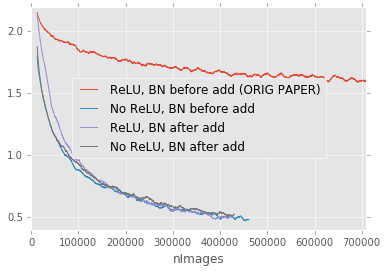

In [50]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "ReLU, BN before add (ORIG PAPER)",
    "201601102044-01lkOBJQu5": "No ReLU, BN before add",
    "201601102047-YybNsWu8zs": "ReLU, BN after add",
    "201601102047-jBrez4iUNB": "No ReLU, BN after add",
}, "Training loss.csv","loss")
pd.rolling_mean(df, 100).plot()


Oops! I should not have a ReLU just before the softmax!

201601102127-YCl5TEh7Wm is just like 201601102039-wgq6T6HuK3 but the
ReLU just before the softmax is gone... The difference is extremely
pronounced.

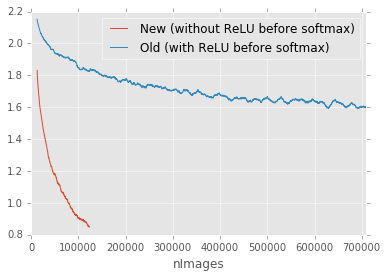

In [51]:
df = wb.meld_csv({
    "201601102039-wgq6T6HuK3": "Old (with ReLU before softmax)",
    "201601102127-YCl5TEh7Wm": "New (without ReLU before softmax)",
    #"201601102044-01lkOBJQu5": "Best (No ReLU, BN before add)", # this doesn't have ReLU
}, "Training loss.csv","loss")
#}, "Testing Error.csv","error")
pd.rolling_mean(df, 100).plot()

# (NEEDS-RERUN) Reproduce the paper. Architecture considerations.

- Batch size: 128
- Layer depth: 20 layers.

Within each block, the paper uses a batch norm before the addition and
a ReLU just after the addition.


In [0]:
experiments = {
"201601102147-dmFfZATnYp": "ReLU, BN before add (ORIG PAPER)",
"201601102148-JGFRVum2Px": "No ReLU, BN before add",
"201601102148-PWCzZEoKlq": "ReLU, BN after add",
"201601102149-BxAtaPsjip": "No ReLU, BN after add",
}
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
df_err = wb.meld_csv(experiments, "Testing Error.csv","error")
df_err.index /= 50000.0; df_err.index.name = "epoch"
pd.rolling_mean(df_loss, 100).plot(title="Training loss (rolling mean over last 100 epochs)", figsize=(20,5), ylim=(0, 0.5))
df_err.drop(np.nan, 0).plot(title="Error")

In [0]:
pd.rolling_mean(df_loss, 100).plot(title="Training loss (rolling mean over last 100 epochs)", xlim=(0, 10))

In [0]:
# Take a look at the last few iterations
df = pd.rolling_mean(df_loss, 1000).loc[170:200].plot(title="Training loss",figsize=(13,5))

In [0]:
pd.ewma(df_err, 1).plot(xlim=(50,210), ylim=(0.05,0.2), title="Test classification error")

In [0]:
df_err.loc[200]
# But there is HUGE variance in the last few ones...
# Actual paper's score was 8.75.


# (NEEDS-RERUN) Impact of network size

In [0]:
import bokeh.plotting as bp
import bokeh.charts as bc
bp.output_notebook()
bc.Line(df_loss.iloc[:,0]).show()

In [0]:
experiments = collections.OrderedDict([
("201601102147-dmFfZATnYp", "Nsize=3 (ORIG PAPER), 20 layers"),
("201601111527-cVRVX20oIx", "Nsize=5, 32 layers"),
("201601111527-OlgppHl97y", "Nsize=7, 44 layers"),
("201601111527-iNT9lvorNt", "Nsize=9, 56 layers"),
("201601111958-eYtj2JhWTU", "Nsize=18, 110 layers, fancy policy"),
])
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
df_err = wb.meld_csv(experiments, "Testing Error.csv","error")
df_err = df_err.sort_index(na_position='first')
df_err.index /= 50000.0; df_err.index.name = "epoch"

In [0]:
pd.rolling_mean(df_loss, 100).plot(title="Training loss (Rolling mean over 100 batches)", figsize=(20,5),
                                   xlim=(0,200), ylim=(0, 0.5))
df_err.plot(title="Error", xlim=(0, 200))

In [0]:
pd.rolling_mean(df_err, 10).plot(xlim=(0,200), ylim=(0.05,0.2), figsize=(10,5), title="Test classification error (Rolling mean over last 10 epochs)")

In [13]:
df_err.iloc[196:201].std()

Nsize=3 (ORIG PAPER), 20 layers       0.004573
Nsize=5, 32 layers                    0.011451
Nsize=7, 44 layers                    0.006902
Nsize=9, 56 layers                    0.008192
Nsize=18, 110 layers, fancy policy    0.004645
dtype: float64

# (NEEDS-RERUN) Effect of alternate optimization strategies

In [17]:
wb["201601102147-dmFfZATnYp"]["Source.git-current-commit"]

'commit 2d158cf0ae5ccfb7443a6d95bfaac1a1b86a8e4c\nAuthor: Michael Wilber <wilmic1102@gmail.com>\nDate:   Sun Jan 10 21:42:02 2016 +0000\n\n    Ready to begin training again\n'

In [15]:
experiments = {
    ## "201601131450-saow6XW51R": "RMSprop, 1.0, alt" # Canceled -- diverging
    ## "201601131447-2hTIt6NxCZ": "RMSprop, 0.1", # Canceled -- diverging
    "201601102147-dmFfZATnYp": "Original paper: Nesterov, 1e-1",
    "201601131652-vZ18rFMlaA": "RMSprop, 1e-4",
    "201601131448-1YL3Dez3iz": "RMSprop, 1e-3",
    "201601131448-jByE90cpvJ": "RMSprop, 1e-2",
    "201601131445-iNohHsKtzn": "Adadelta, rho = 0.3",
    "201601131449-dXGQwyuKDi": "Adagrad, 1e-3",
    "201601131449-j72vjuG7ri": "Adagrad, 1e-2",
    "201601131449-qrxCZezDp4": "Adagrad, 1e-1",
}
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
df_error = wb.meld_csv(experiments, "Testing Error.csv","error")
df_error.index /= 50000.0; df_error.index.name = "epoch"
df_error = df_error.sort_index(na_position='first')

In [0]:
pd.rolling_mean(df_loss, 100).plot(
    title="Training loss (Rolling mean over 100 batches)",
    figsize=(20,5),
    xlim = (0.0, 200.0),
    ylim = (0.0, 2),
)

In [0]:
df_error.plot(xlim=(0,200), figsize=(10,5))

# (NEEDS-RERUN) Kaiming suggests using smaller batchnorm momentum

The NVIDIA CuDNNv4 documentation suggests setting momentum to 1/(1+n)
at every iteration. This should give us more stable testing
convergence.

Kaiming wrote back with the following clue:

    1. I noticed that you observed the results are unstable. This may be
    caused by your way of doing BN (I am sorry that I have not checked the
    code as I am not familiar with Torch). In particular, the way of doing
    BN at test-time seems important. In our implementation, the BN
    statistics (mean/var) used for testing are computed on (virtually) all
    training images, and in practice, a very large batch of training image
    will provide statistically the same BN statistics. If you compute BN
    mean/var for testing on a mini-batch that is too small, the results
    might be unstable. In my experiments, the variations of stopping at
    different final epochs of a single run is within 0.1-0.2%; but "more
    than half of a percent" sounds too much for me. Besides, the
    training-time implementation of BN also seems to matter.

So this experiment is using the batch normalization strategy suggested
by the nvidia documentation.

From printing updates, I see that CuDNN's BN has the following behavior:

- Momentum=0 implies updates don't happen at all.
- Momentum=1 implies that the update happens within every batch.


In [11]:
experiments = {
    "201601102147-dmFfZATnYp": "Original paper: BN momentum = 0.1",
    #"201601132000-cbJKfytCch": "BN, dynamic momentum = 1/(1+n)", # canceled
    "201601131859-y1bpVLfBQN": "BN, momentum = 0.01",
    "201601132007-Z9bCodabdH": "BN, momentum=1 just for fun",
    "201601132032-JKqkUYgUQw": "Dynamic, but based on epoch size",
    "201601132225-URWjAnkUlG": "Dynamic, reset every epoch.",
#"": "BN, dynamic momentum = 1 - 1/(1+n)",
#"": "BN, momentum = 0.99",
#"": "BN, momentum = 0.9",
}
df_loss = wb.meld_csv(experiments, "Training loss.csv","loss")
df_loss.index /= 50000.0; df_loss.index.name = "epoch"
df_err = wb.meld_csv(experiments, "Testing Error.csv","error")
df_err = df_err.sort_index(na_position='first')
df_err.index /= 50000.0; df_err.index.name = "epoch"

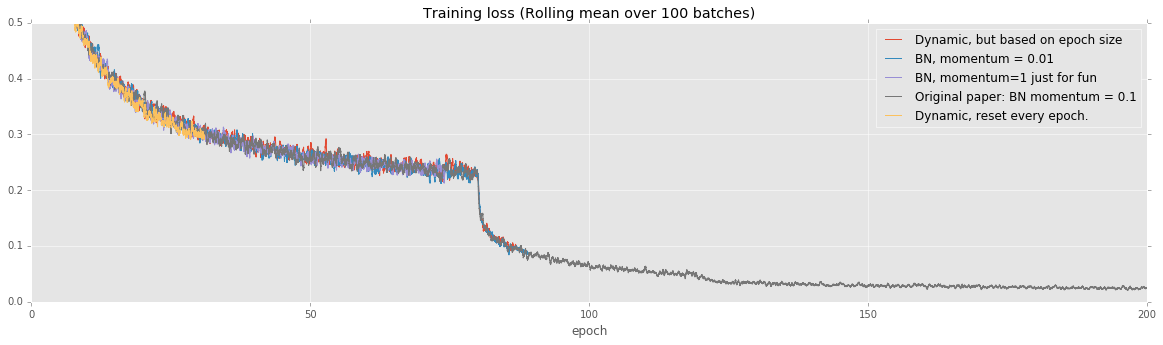

In [14]:
pd.rolling_mean(df_loss,100).plot(
    title="Training loss (Rolling mean over 100 batches)",
    figsize=(20,5),
    xlim = (0.0, 200.0),
    ylim = (0.0, 0.5),
)

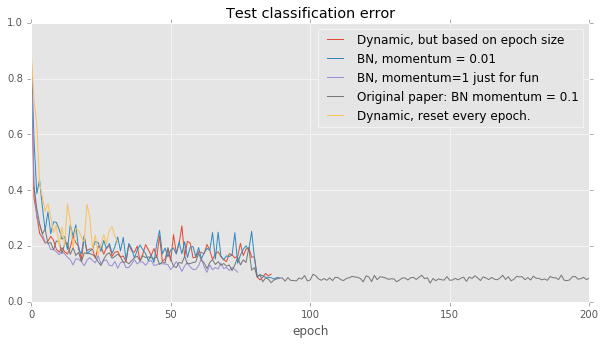

In [13]:
pd.rolling_mean(df_err, 1).plot(xlim=(0, 200), title="Test classification error", figsize=(10,5))